In [141]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from collections import defaultdict
from tqdm import tnrange as trange, tqdm_notebook as tqdm
plt.style.use('dark_background')
import matplotlib.patches as mpatches

In [185]:
class Env:
    def __init__(self):
        self.n = 6  # num of rows
        self.m = 9  # num of cols
        self.n_actions = 4  # to query from Trainer if needed
        self.goal_state = np.array([0, 8])
        self.blocked_states = [(3, i) for i in range(1, self.m)]
        self.reset()
        
    def reset(self):
        self.state = (5, 3)  # current row and col numbers correspondingly
        self.done = False

    def create_shortcut(self):
        self.blocked_states = [(3, i) for i in range(1, self.m-1)]  # stop blocking rightmost cell in mid row
        
    def act(self, action_i):
        '''Actions: 0 up, 1 right, 2 down, 3 left
        '''
        if action_i == 0 and self.state[0] != 0 and (self.state[0]-1, self.state[1]) not in self.blocked_states:
            self.state = (self.state[0]-1, self.state[1])
        if action_i == 1 and self.state[1] != self.m-1 and (self.state[0], self.state[1]+1) not in self.blocked_states:
            self.state = (self.state[0], self.state[1]+1)
        if action_i == 2 and self.state[0] != self.n-1 and (self.state[0]+1, self.state[1]) not in self.blocked_states:
            self.state = (self.state[0]+1, self.state[1])
        if action_i == 3 and self.state[1] != 0 and (self.state[0], self.state[1]-1) not in self.blocked_states:
            self.state = (self.state[0], self.state[1]-1)
        if action_i < 0 or action_i > self.n_actions-1:
            raise Exception
        
        if np.allclose(self.state, self.goal_state):
            self.done = True
            return 1  # reward of 1 just on goal state
        return 0

In [189]:
class Trainer:
    def __init__(self, gamma, alpha, eps, planning_steps, k, action_k):
        '''gamma - discounting factor
        alpha - update step size
        eps - for eps-greedy policy
        planning_steps - how many planning steps per real step
        k - coefficient of exploratory bonus in planning
        action_k - coefficient of exploratory bonus in action selection
        '''
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps
        self.planning_steps = planning_steps
        self.k = k
        self.action_k = action_k
        
        self.env = Env()
        self.q = np.zeros([self.env.n, self.env.m, self.env.n_actions])
        self.time_since_tried = np.zeros([self.env.n, self.env.m, self.env.n_actions])
        self.visited_states = []
        self.visited_state_actions = defaultdict(list)
        self.model = {}  # (S, A) -> (R, S')
        
    def train(self, iters):
        steps_counts = []
        for i in trange(iters):
            steps_completed = self.episode()
            steps_counts.append(steps_completed)
        self.env.create_shortcut()
        for i in trange(iters):
            steps_completed = self.episode()
            steps_counts.append(steps_completed)
        return steps_counts
        
    def episode(self):
        steps_completed = 0
        while not self.env.done:
            self.iter()
            steps_completed += 1
        self.env.reset()
        return steps_completed
        
    def eps_greedy_action(self, state):
        if np.random.binomial(n=1, p=self.eps):
            action_i = np.random.randint(self.env.n_actions)
        else:
            action_i = self.greedy_explor_action(state)
        return action_i
    
    def greedy_action(self, state):  # for q-learning update
        return np.argmax(self.q[state[0], state[1], :])
    
    def greedy_explor_action(self, state):
        return np.argmax(self.q[state[0], state[1], :] + self.action_k * np.sqrt(self.time_since_tried[state[0], state[1], :]))
        
    def update_q(self, state, action_i, reward, next_state):
        next_action_i = self.greedy_action(next_state)
        max_next_q = self.q[next_state[0], next_state[1], next_action_i]
        reward += self.k * np.sqrt(self.time_since_tried[state[0], state[1], action_i])  # additional exploration bonus
        self.q[state[0], state[1], action_i] += self.alpha * (reward + self.gamma * max_next_q - self.q[state[0], state[1], action_i])
        
    def iter(self):
        action_i = self.eps_greedy_action(self.env.state)
        self.time_since_tried[self.env.state[0], self.env.state[1], action_i] = 0
        prev_state = self.env.state
        reward = self.env.act(action_i)
        next_state = self.env.state
        self.update_q(prev_state, action_i, reward, next_state)
        self.visited_states.append(prev_state)
        self.visited_state_actions[prev_state].append(action_i)
        self.model[(prev_state, action_i)] = (reward, next_state)
        
        # planning
        for i in range(self.planning_steps):
            if self.k == 0:  # original option, without additional exploration
                state = random.choice(self.visited_states)
                action_i = random.choice(self.visited_state_actions[state])
            else:
                state = (np.random.randint(self.env.n), np.random.randint(self.env.m))
                action_i = np.random.randint(self.env.n_actions)
                if (state, action_i) not in self.model:
                    self.model[(state, action_i)] = (0, state)
            reward, next_state = self.model[(state, action_i)]
            self.update_q(state, action_i, reward, next_state)
        self.time_since_tried += 1  # for all (S, A) pairs

In [190]:
def get_cum_reward(steps_counts):
    cum_reward = np.zeros(np.array(steps_counts).sum())
    cur_init_timestep = 0
    for episodes_ended, steps_num in enumerate(steps_counts):
        for inner_step in range(cur_init_timestep, cur_init_timestep + steps_num):
            cum_reward[inner_step] = episodes_ended
        cur_init_timestep += steps_num
    return cum_reward

In [191]:
def print_greedy_sequence():
    env = Env()
    # state_action = tuple(env.state), trainer.greedy_action(env.state)
    while not env.done:
        action_i = trainer.greedy_action(env.state)
        env.act(action_i)
        print(action_i)

In [192]:
def train(**params):
    trainer = Trainer(**params)
    iters = 100
    steps_counts = trainer.train(iters)
    print(f'Last lengths of episodes: {steps_counts[195:200]}')
    cum_reward = get_cum_reward(steps_counts)
    
    plt.figure(figsize=(8, 3))
    plt.semilogy(steps_counts)
    plt.xlabel('Episodes')
    plt.ylabel('Episode length')
    
    plt.figure(figsize=(8, 3))
    plt.plot(cum_reward)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative reward')
    
    cum_reward_opened = get_cum_reward(steps_counts[iters:])
    return steps_counts, cum_reward, cum_reward_opened


Last lengths of episodes: [18, 20, 18, 16, 18]


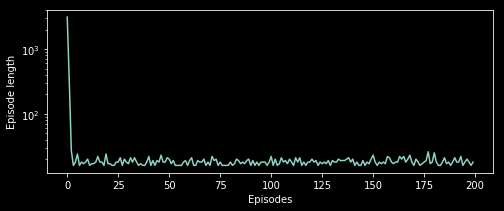

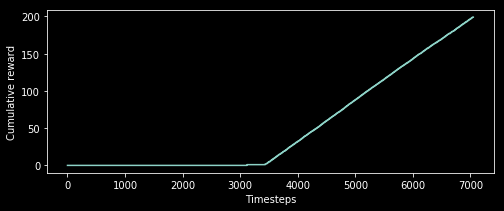

In [182]:
steps_counts, cum_reward_orig, cum_reward_opened_orig = train(gamma=0.95, alpha=0.1, eps=0.1, planning_steps=40, k=0, action_k=0)


Last lengths of episodes: [14, 13, 12, 10, 10]


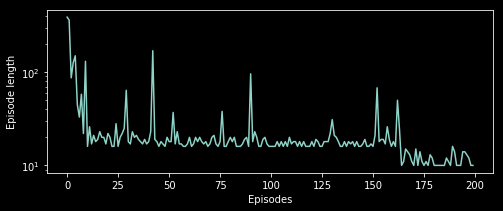

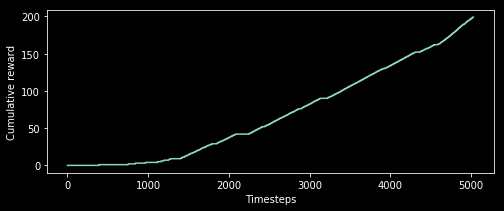

In [153]:
steps_counts, cum_reward_explor, cum_reward_opened_explor = train(gamma=0.95, alpha=0.1, eps=0.1, planning_steps=40, k=1e-1)


Last lengths of episodes: [10, 10, 10, 11, 10]


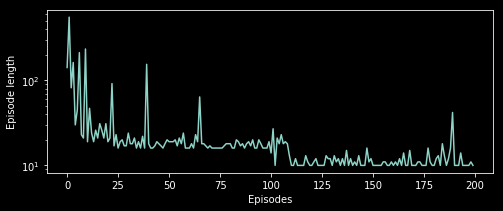

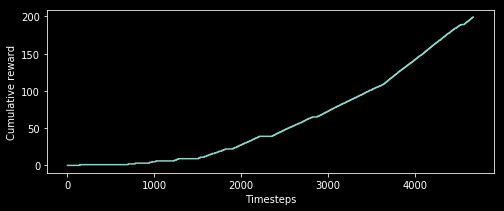

In [154]:
steps_counts, cum_reward_explor_strong, cum_reward_opened_explor_strong = train(gamma=0.95, alpha=0.1, eps=0.1, planning_steps=40, k=1)

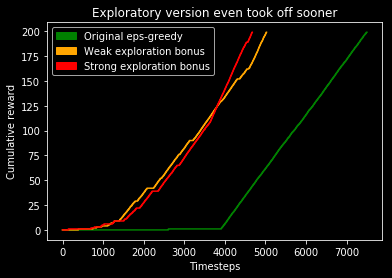

In [161]:
plt.plot(cum_reward_orig, color='green')
plt.plot(cum_reward_explor, color='orange')
plt.plot(cum_reward_explor_strong, color='red')
plt.xlabel('Timesteps')
plt.ylabel('Cumulative reward')
plt.legend(handles=[mpatches.Patch(color='green', label='Original eps-greedy'),
                    mpatches.Patch(color='orange', label='Weak exploration bonus'),
                    mpatches.Patch(color='red', label='Strong exploration bonus'),])
text = plt.title('Exploratory version even took off sooner')

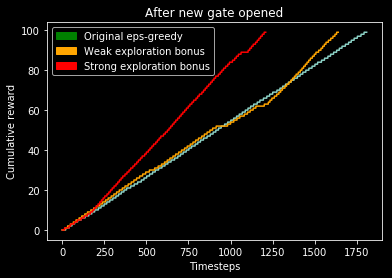

In [163]:
plt.plot(cum_reward_opened_orig)
plt.plot(cum_reward_opened_explor, color='orange')
plt.plot(cum_reward_opened_explor_strong, color='red')
plt.xlabel('Timesteps')
plt.ylabel('Cumulative reward')
plt.legend(handles=[mpatches.Patch(color='green', label='Original eps-greedy'),
                    mpatches.Patch(color='orange', label='Weak exploration bonus'),
                    mpatches.Patch(color='red', label='Strong exploration bonus'),])
text = plt.title('After new gate opened')

Results: larger k => greater slowdown but greater probability of discovering new benefits.

(Actually it's possible to implement the additions described in the footnote of p.168 and this would generalize original algorithm with only eps-greedy exploration.

But practically it would only slow down planning considerably, especially in the beginning, since it would also consider states for which no information is available yet.)


Last lengths of episodes: [17, 18, 16, 21, 16]


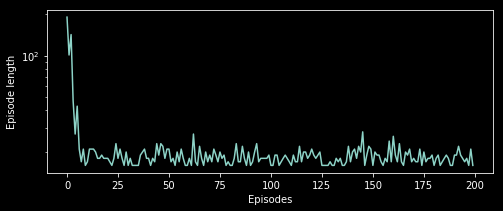

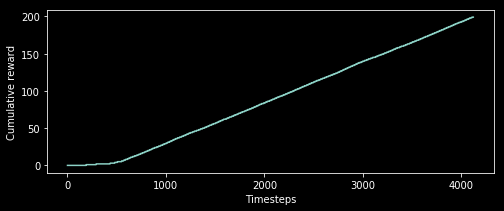

In [183]:
steps_counts, cum_reward_explor_action, cum_reward_opened_explor_action = train(gamma=0.95,
    alpha=0.1, eps=0.1, planning_steps=40, k=0, action_k=1e-3)


Last lengths of episodes: [118, 121, 59, 198, 134]


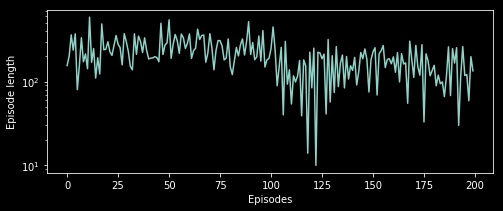

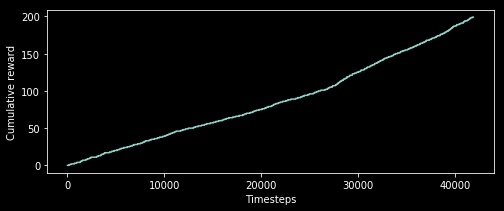

In [194]:
steps_counts, cum_reward_explor_action, cum_reward_opened_explor_action = train(gamma=0.95,
    alpha=0.1, eps=0.1, planning_steps=40, k=0, action_k=1e-)


Last lengths of episodes: [47, 50, 54, 53, 57]


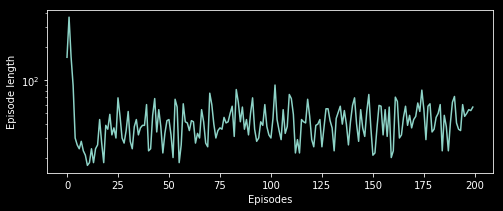

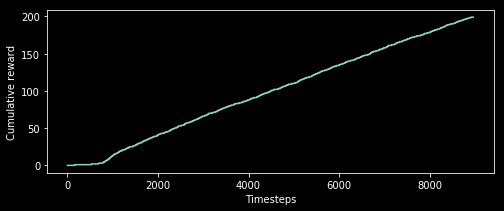

In [209]:
steps_counts, cum_reward_explor_action, cum_reward_opened_explor_action = train(gamma=0.95,
    alpha=0.1, eps=0.1, planning_steps=40, k=0, action_k=1e-2)

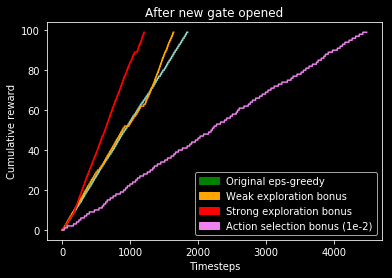

In [210]:
plt.plot(cum_reward_opened_orig)
plt.plot(cum_reward_opened_explor, color='orange')
plt.plot(cum_reward_opened_explor_strong, color='red')
plt.plot(cum_reward_opened_explor_action, color='violet')
plt.xlabel('Timesteps')
plt.ylabel('Cumulative reward')
plt.legend(handles=[mpatches.Patch(color='green', label='Original eps-greedy'),
                    mpatches.Patch(color='orange', label='Weak exploration bonus'),
                    mpatches.Patch(color='red', label='Strong exploration bonus'),
                    mpatches.Patch(color='violet', label='Action selection bonus (1e-2)')])
text = plt.title('After new gate opened')

Exploration bonus on action selection step has no positive effect at any bonus coefficient values action_k and really disturbs the training at larger values of action_k.

Seems like this method with reasonable values of action_k causes policy to deviate from optimal route really frequently even after convergence - more frequently than the situation would necessitate.